In [29]:
!pip install osmnx

In [30]:
import csv
import time
import osmnx as ox
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from shapely.geometry import Point, Polygon
from shapely.geometry import LineString, Point
import geopandas as gpd
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde
import networkx as nx
import random


In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
# Define the CSV filename
csv_filename = "/content/drive/My Drive/ECE1724/google_places_data.csv"

In [33]:
# Define the downtown Toronto polygon with coordinates
downtown_coords = [
    (-79.39676885340909, 43.633998833462236),
    (-79.39174809486369, 43.63682905026097),
    (-79.39180222587885, 43.63694004931786),
    (-79.37961922412661, 43.63805717651655),
    (-79.3468174597412, 43.65092073796034),
    (-79.35398144869377, 43.65816936456624),
    (-79.35756328753453, 43.67023482801587),
    (-79.36103265363431, 43.67410944189455),
    (-79.36153690891551, 43.67559933274478),
    (-79.36690093311692, 43.674710870347575),
    (-79.37115924145583, 43.6721398690731),
    (-79.37625006956276, 43.672635599518166),
    (-79.41145557057517, 43.66528235096095),
    (-79.39948611861924, 43.63591770508141),
    (-79.39839745248081, 43.635564257855684)
]
downtown_polygon = Polygon(downtown_coords)

In [34]:
# Load the saved CSV data into a DataFrame
places_df = pd.read_csv(csv_filename)

# Convert the latitude and longitude to geometric points
geometry = [Point(xy) for xy in zip(places_df["Longitude"], places_df["Latitude"])]
poi_gdf = gpd.GeoDataFrame(places_df, geometry=geometry, crs="EPSG:4326")

# Filter places of interest within the downtown polygon
poi_within_downtown = poi_gdf[poi_gdf.geometry.within(downtown_polygon)]

In [35]:
# Define colors for each type of POI
poi_colors = {
    "amusement_park": "purple",
    "aquarium": "blue",
    "art_gallery": "orange",
    "bakery": "brown",
    "bar": "red",
    "beauty_salon": "pink",
    "book_store": "lightgreen",
    "bowling_alley": "lightblue",
    "cafe": "green",
    "campground": "darkgreen",
    "casino": "darkred",
    "church": "cyan",
    "city_hall": "darkorange",
    "clothing_store": "violet",
    "convenience_store": "coral",
    "department_store": "teal",
    "embassy": "navy",
    "florist": "lime",
    "gym": "olive",
    "hair_care": "plum",
    "hindu_temple": "maroon",
    "jewelry_store": "gold",
    "library": "turquoise",
    "lodging": "salmon",
    "mosque": "aqua",
    "movie_theater": "purple",
    "museum": "yellow",
    "night_club": "magenta",
    "park": "forestgreen",
    "pharmacy": "skyblue",
    "restaurant": "chocolate",
    "shopping_mall": "lightcoral",
    "spa": "orchid",
    "stadium": "steelblue",
    "store": "slategray",
    "subway_station": "tomato",
    "synagogue": "sienna",
    "tourist_attraction": "lavender",
    "train_station": "indigo",
    "transit_station": "peru",
    "travel_agency": "fuchsia",
    "university": "khaki",
    "zoo": "goldenrod",
    "restaurant": "dodgerblue"
}

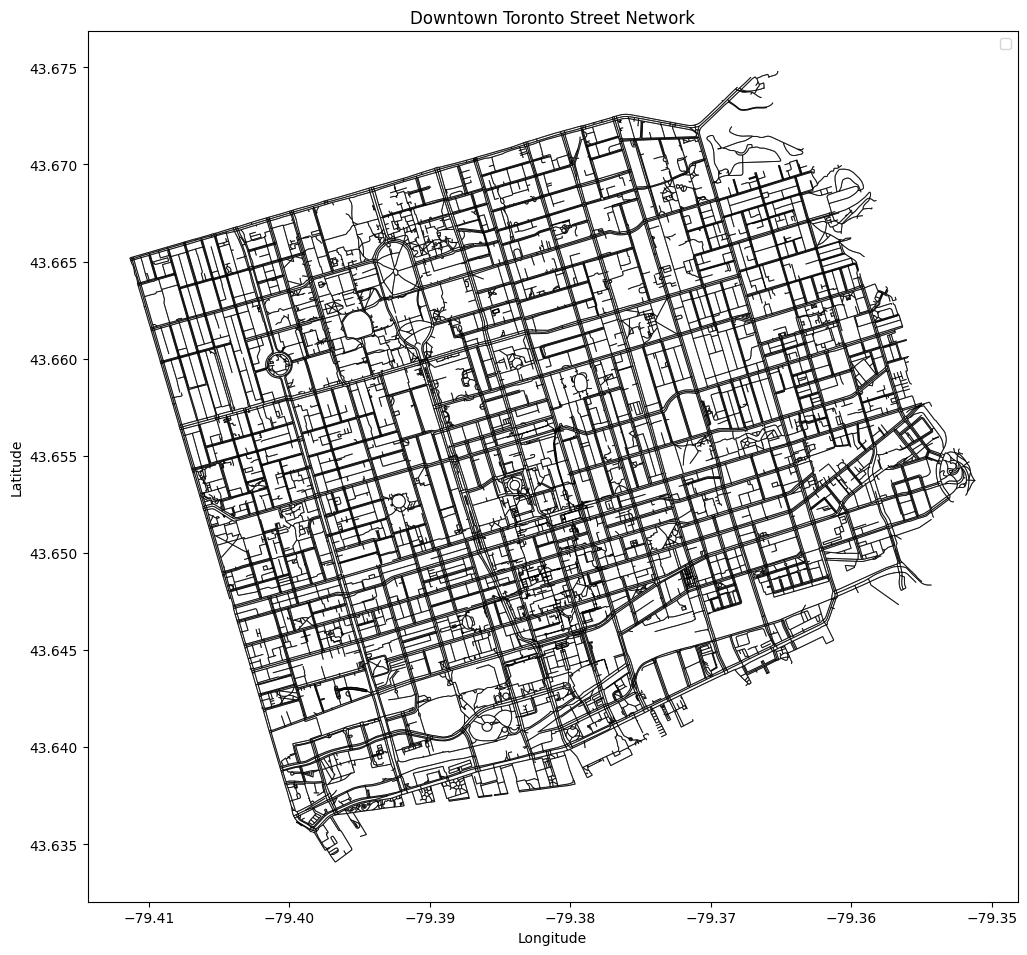

In [36]:
# Graph 1

# Download the street network within the downtown polygon
G = ox.graph_from_polygon(downtown_polygon, network_type='walk')

# Extract nodes and edges as GeoDataFrames
nodes, edges = ox.graph_to_gdfs(G)
intersections = nodes[nodes['street_count'] > 1]  # Filter to only intersection nodes

# Plot 1: Network with intersections only (no POIs)
fig, ax = plt.subplots(figsize=(12, 12))
edges.plot(ax=ax, linewidth=0.7, color="black", alpha=0.7)


plt.legend()
plt.title("Downtown Toronto Street Network")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [37]:
G = ox.graph_from_polygon(downtown_polygon, network_type='walk')

# Extract nodes and edges as GeoDataFrames
nodes, edges = ox.graph_to_gdfs(G)
intersections = nodes[nodes['street_count'] > 1]  # Filter to only intersection nodes

Selected Node Information:
y                                    43.639088
x                                   -79.396572
highway                                    NaN
street_count                                 3
railway                                    NaN
ref                                        NaN
geometry        POINT (-79.3965719 43.6390877)
Name: 3049727545, dtype: object


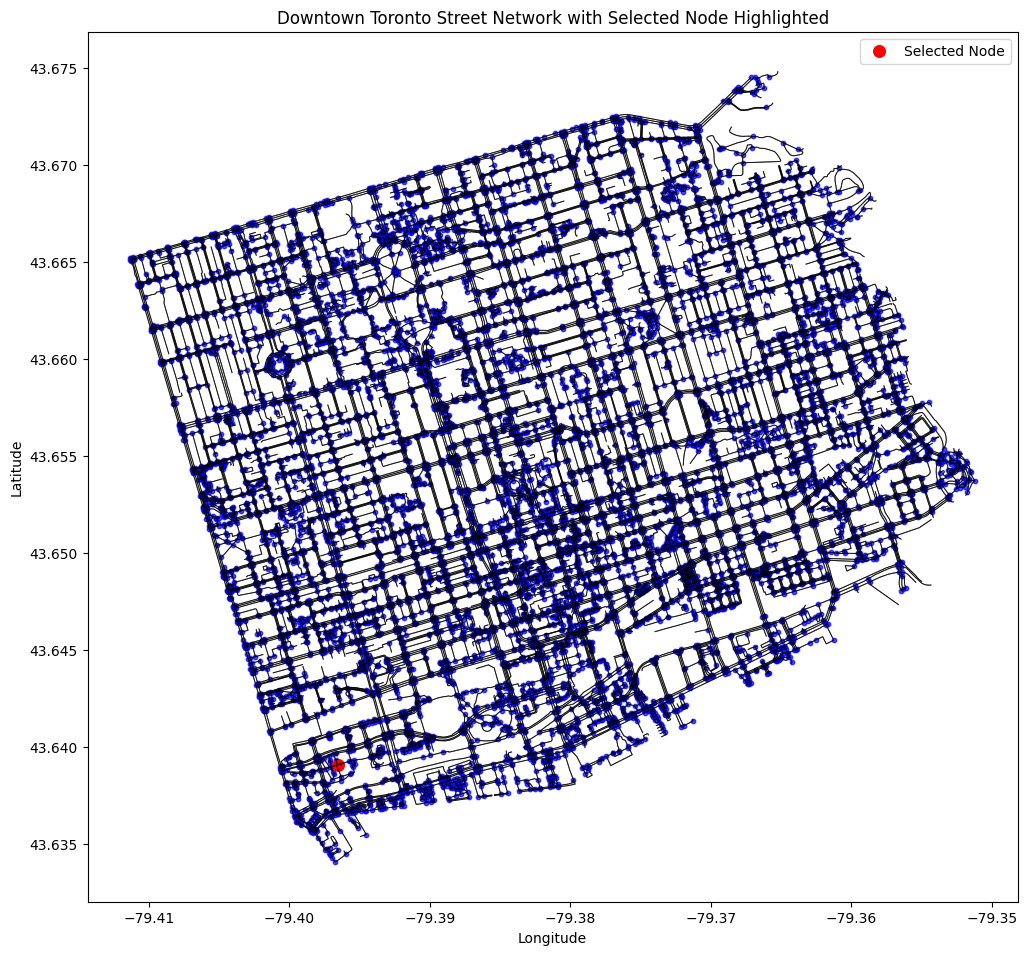

In [38]:
# Randomly select a node
selected_node = intersections.sample(1)  # Randomly sample one node
node_info = selected_node.iloc[0]  # Extract the node information
print("Selected Node Information:")
print(node_info)

# Plot the network with the selected node highlighted in red
fig, ax = plt.subplots(figsize=(12, 12))
edges.plot(ax=ax, linewidth=0.7, color="black", alpha=0.7)
intersections.plot(ax=ax, markersize=10, color="blue", alpha=0.7)  # Plot all intersections in blue

# Highlight the selected node
selected_node.plot(ax=ax, color="red", markersize=70, label="Selected Node")

# Add plot details
plt.legend()
plt.title("Downtown Toronto Street Network with Selected Node Highlighted")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

Random route with 10 edges found and highlighted. Total length: 287.57 meters


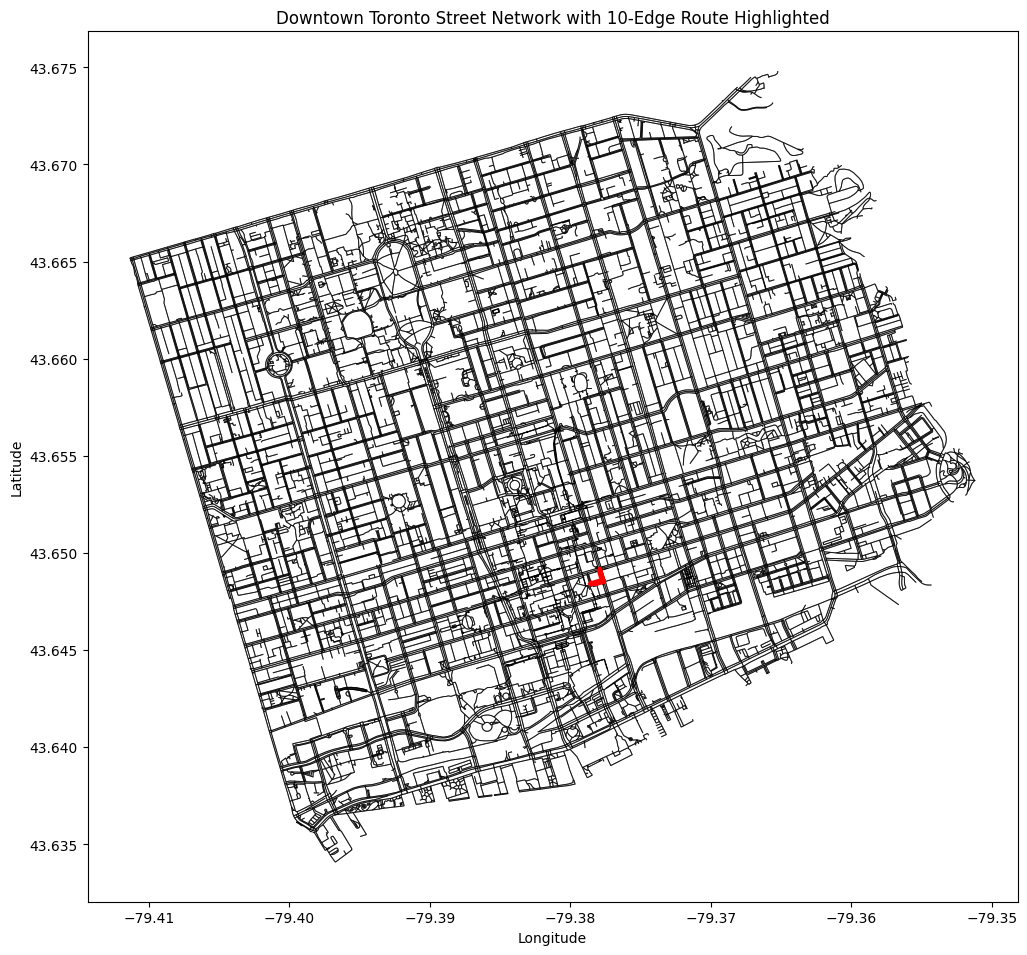

In [39]:
# Graph 2

# Randomly choose a starting node
start_node = random.choice(list(G.nodes))

# Initialize variables for route, length, and visited nodes
route = []
total_length = 0
current_node = start_node
visited_nodes = {start_node}

# Build a route with exactly 10 edges without revisiting nodes
for _ in range(10):
    # Get all neighbors of the current node that haven't been visited
    neighbors = [n for n in G.neighbors(current_node) if n not in visited_nodes]

    # If there are no unvisited neighbors, stop
    if not neighbors:
        break

    # Randomly select a neighbor to move to
    next_node = random.choice(neighbors)

    # Check if the edge exists and has a 'length' attribute
    edge_data = G.get_edge_data(current_node, next_node, 0)
    if edge_data and 'length' in edge_data:
        route.append((current_node, next_node))
        total_length += edge_data['length']

        # Move to the next node and mark it as visited
        current_node = next_node
        visited_nodes.add(current_node)
    else:
        break  # Stop if we can't find a valid edge

# Extract nodes and edges as GeoDataFrames
nodes, edges = ox.graph_to_gdfs(G)
intersections = nodes[nodes['street_count'] > 1]  # Filter to only intersection nodes

# Plot the network
fig, ax = plt.subplots(figsize=(12, 12))
edges.plot(ax=ax, linewidth=0.7, color="black", alpha=0.7)

# Highlight the route if found
if len(route) == 10:
    for u, v in route:
        edge_data = G.edges[u, v, 0]

        # Check if 'geometry' exists; if not, create a simple line between nodes
        if 'geometry' in edge_data:
            edge_geom = edge_data['geometry']
        else:
            # Get coordinates of the nodes to create a straight line
            x_start, y_start = G.nodes[u]['x'], G.nodes[u]['y']
            x_end, y_end = G.nodes[v]['x'], G.nodes[v]['y']
            edge_geom = [(x_start, y_start), (x_end, y_end)]

        # Plot the edge in red
        if isinstance(edge_geom, list):  # Case where geometry is manually created
            x_coords, y_coords = zip(*edge_geom)
            ax.plot(x_coords, y_coords, color='red', linewidth=3)
        else:  # Case where geometry exists as a LineString
            ax.plot(*edge_geom.xy, color='red', linewidth=3)

    print(f"Random route with 10 edges found and highlighted. Total length: {total_length:.2f} meters")
else:
    print("Could not construct a route with exactly 10 edges.")

plt.title("Downtown Toronto Street Network with 10-Edge Route Highlighted")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

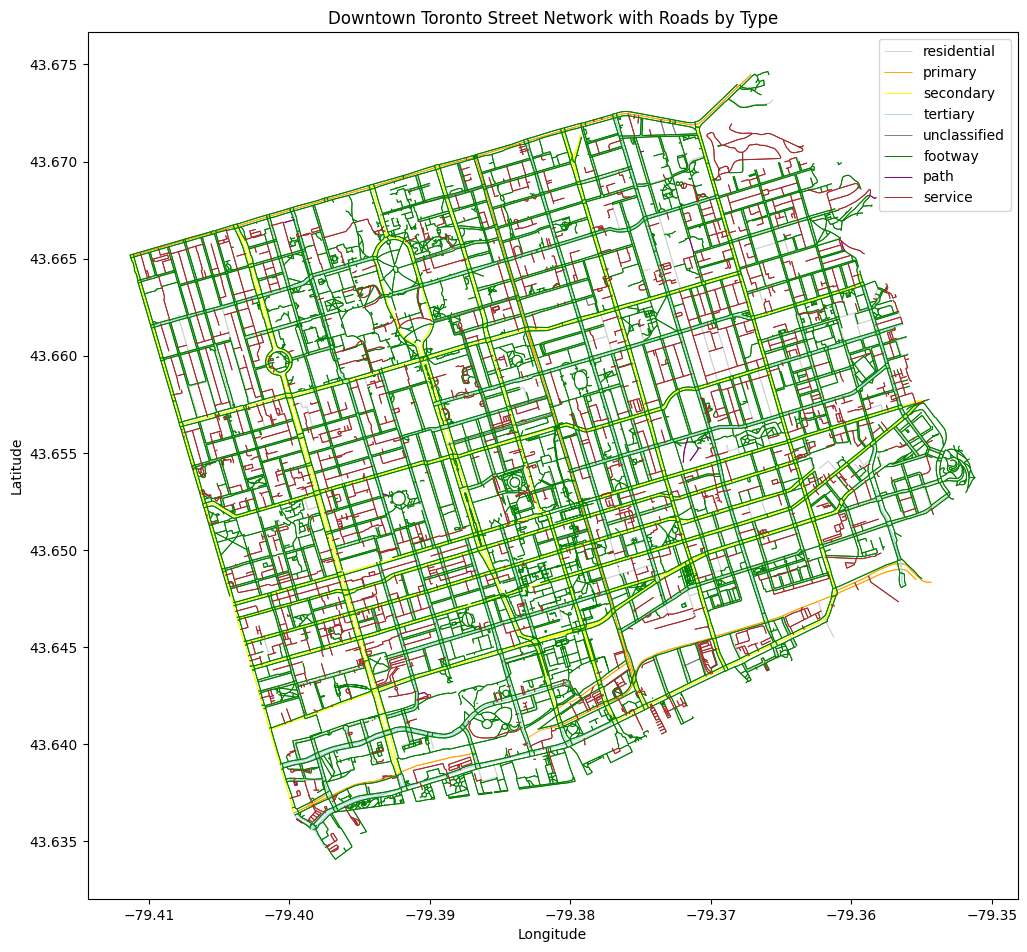

In [40]:
# Graph 3

# Define colors for each type of road
road_colors = {
    'residential': 'lightgrey',
    'primary': 'orange',
    'secondary': 'yellow',
    'tertiary': 'lightblue',
    'unclassified': 'grey',
    'footway': 'green',
    'path': 'purple',
    'cycleway': 'blue',
    'service': 'brown',
    'track': 'pink',
    'other': 'black'  # fallback color for unspecified types
}


# Ensure that each road has a known type; otherwise, set it to 'other'
edges['highway'] = edges['highway'].apply(lambda x: x[0] if isinstance(x, list) else x)
edges['highway'] = edges['highway'].fillna('other')

# Plot the network with different colors for each type of road
fig, ax = plt.subplots(figsize=(12, 12))
for road_type, color in road_colors.items():
    road_subset = edges[edges['highway'] == road_type]
    if not road_subset.empty:
        road_subset.plot(ax=ax, linewidth=0.7, color=color, label=road_type)


# Add legend and labels
plt.legend()
plt.title("Downtown Toronto Street Network with Roads by Type")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


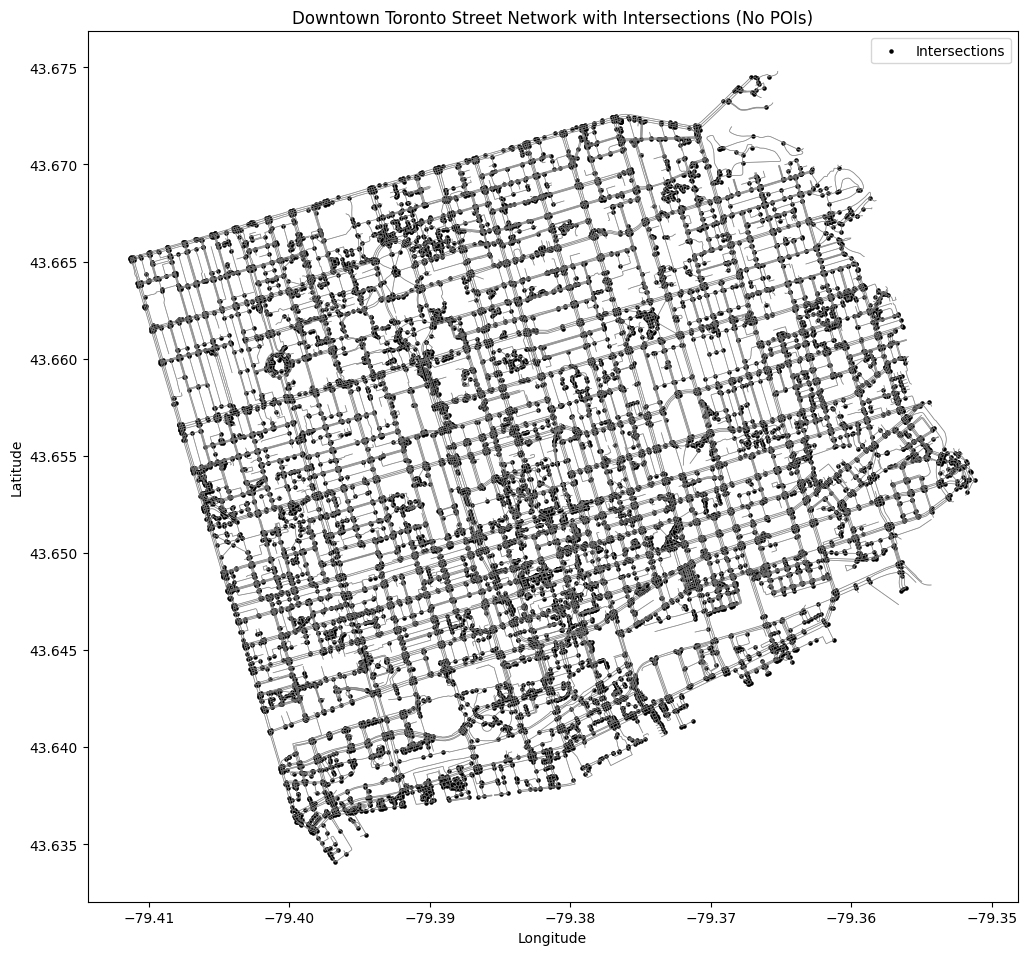

In [41]:
# Graph 4

# Extract nodes and edges as GeoDataFrames
nodes, edges = ox.graph_to_gdfs(G)
intersections = nodes[nodes['street_count'] > 1]  # Filter to only intersection nodes

# Plot 1: Network with intersections only (no POIs)
fig, ax = plt.subplots(figsize=(12, 12))
edges.plot(ax=ax, linewidth=0.5, color="gray", alpha=0.7)
intersections.plot(ax=ax, color="black", markersize=5, label="Intersections")

plt.legend()
plt.title("Downtown Toronto Street Network with Intersections (No POIs)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

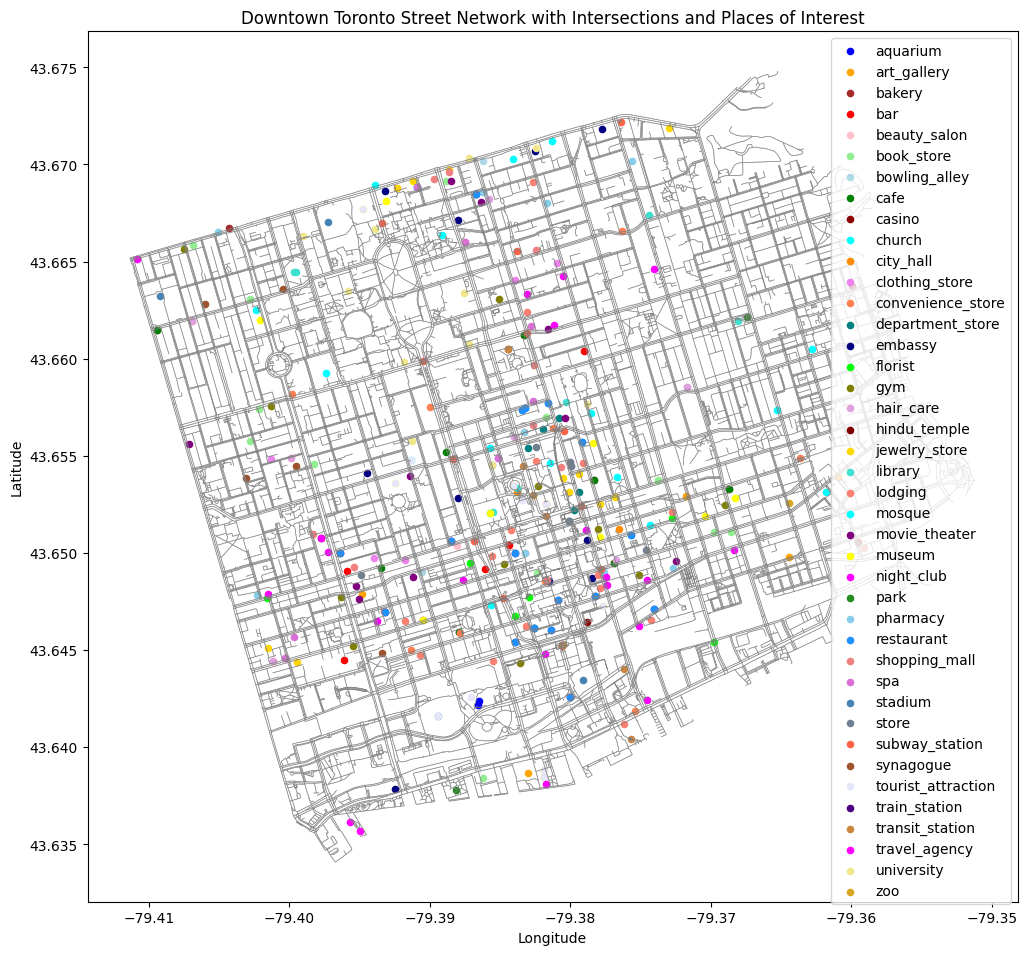

In [42]:
# Graph 5

fig, ax = plt.subplots(figsize=(12, 12))
edges.plot(ax=ax, linewidth=0.5, color="gray", alpha=0.7)
# intersections.plot(ax=ax, color="black", markersize=1, label="Intersections")

# Plot each POI type with a different color
for poi_type, color in poi_colors.items():
    poi_subset = poi_within_downtown[poi_within_downtown["Type"] == poi_type]
    if not poi_subset.empty:  # Only plot if there are points of this type
        poi_subset.plot(ax=ax, color=color, markersize=20, label=poi_type)

plt.legend()
plt.title("Downtown Toronto Street Network with Intersections and Places of Interest")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# Define an Interest Score (I) for each POI that takes into account:
Review Score (R) - This is the average rating of the POI (e.g., from 1 to 5).
Number of Reviews (N) - The total number of reviews for the POI, indicating its popularity.

## A simple formula could be:
##### I=R×log(1+N)

## Explanation:
R (Review Score): Higher ratings contribute directly to a higher Interest Score.

log(1+N) (Logarithm of the Number of Reviews): This term increases the score proportionally to the number of reviews, giving a diminishing effect for very high numbers of reviews.

The logarithmic function is helpful because it emphasizes differences at low review counts while limiting the effect at high counts, balancing popularity without overly favoring high-review POIs.

In [43]:
# Define the Interest Score formula
def calculate_interest_score(row):
    review_score = row["Rating"] if not pd.isna(row["Rating"]) else 0  # Default to 0 if NaN
    num_reviews = row["Total User Ratings"] if not pd.isna(row["Total User Ratings"]) else 0  # Default to 0 if NaN
    # Calculate the Interest Score
    return review_score * np.log1p(num_reviews)  # np.log1p(x) is log(1 + x)

# Apply the formula to each POI and store it in a new column
places_df["Interest Score"] = places_df.apply(calculate_interest_score, axis=1)

# Display the top 5 POIs with the highest Interest Score for verification
places_df.sort_values(by="Interest Score", ascending=False)

Type                                  Name  \
638  tourist_attraction                              CN Tower   
8              aquarium           Ripley's Aquarium of Canada   
424              museum                  Royal Ontario Museum   
641  tourist_attraction                  Royal Ontario Museum   
645  tourist_attraction                Nathan Phillips Square   
..                  ...                                   ...   
439              museum                    Tatar Art Projects   
172           city_hall                           Hempensburg   
171           city_hall  Quayside Impact Partnership Limited.   
170           city_hall                          Paul Ainslie   
147              casino               Canadian Majesty Casino   

                                   Address  Rating  Total User Ratings  \
638         290 Bremner Boulevard, Toronto     4.6             75213.0   
8           288 Bremner Boulevard, Toronto     4.6             60314.0   
424               100 Queens Park, Toronto     4.7             36974.0   
641               100 Queens Park, Toronto     4.7             36974.0   
645         100 Queen Street West, Toronto     4.6             37232.0   
..                                     ...     ...                 ...   
439  147 Liberty Street Suite 202, Toronto     NaN                 NaN   
172             411 Duplex Avenue, Toronto     NaN                 NaN   
171  30 Adelaide Street East #301, Toronto     NaN                 NaN   
170         100 Queen Street West, Toronto     NaN                 NaN   
147            736 Don Mills Road, Toronto     NaN                 NaN   

                        Place ID  \
638  ChIJmzrzi9Y0K4gRgXUc3sTY7RU   
8    ChIJWwS21dU0K4gRPSGMKRkar40   
424  ChIJE-Xa87o0K4gRkvXFHuE0hMk   
641  ChIJE-Xa87o0K4gRkvXFHuE0hMk   
645  ChIJBxZ2UMw0K4gR1LmKMBvveP0   
..                           ...   
439  ChIJr5GtwN40K4gRNqKYy4ZY66s   
172  ChIJFTXCG_UzK4gRy5fb6WCFF6U   
171  ChIJGwDAszPL1IkRK8ANJGtc1q0   
170  ChIJ1fmfaMw0K4gRTn8hWGmAZMc   
147  ChIJgf63JD_N1IkRsim9PF-JIxY   

                                                 Types   Latitude  Longitude  \
638  tourist_attraction, point_of_interest, establi...  43.642566 -79.387057   
8           aquarium, point_of_interest, establishment  43.642178 -79.386602   
424  tourist_attraction, museum, point_of_interest,...  43.667710 -79.394777   
641  tourist_attraction, museum, point_of_interest,...  43.667710 -79.394777   
645  tourist_attraction, point_of_interest, establi...  43.652707 -79.383414   
..                                                 ...        ...        ...   
439  art_gallery, museum, local_government_office, ...  43.637403 -79.424385   
172  city_hall, local_government_office, point_of_i...  43.707442 -79.400081   
171  city_hall, local_government_office, point_of_i...  43.651230 -79.376562   
170  city_hall, local_government_office, point_of_i...  43.653109 -79.383834   
147           casino, point_of_interest, establishment  43.713887 -79.334913   

     Interest Score  
638       51.649226  
8         50.633746  
424       49.434587  
641       49.434587  
645       48.414773  
..              ...  
439        0.000000  
172        0.000000  
171        0.000000  
170        0.000000  
147        0.000000  

[747 rows x 10 columns]

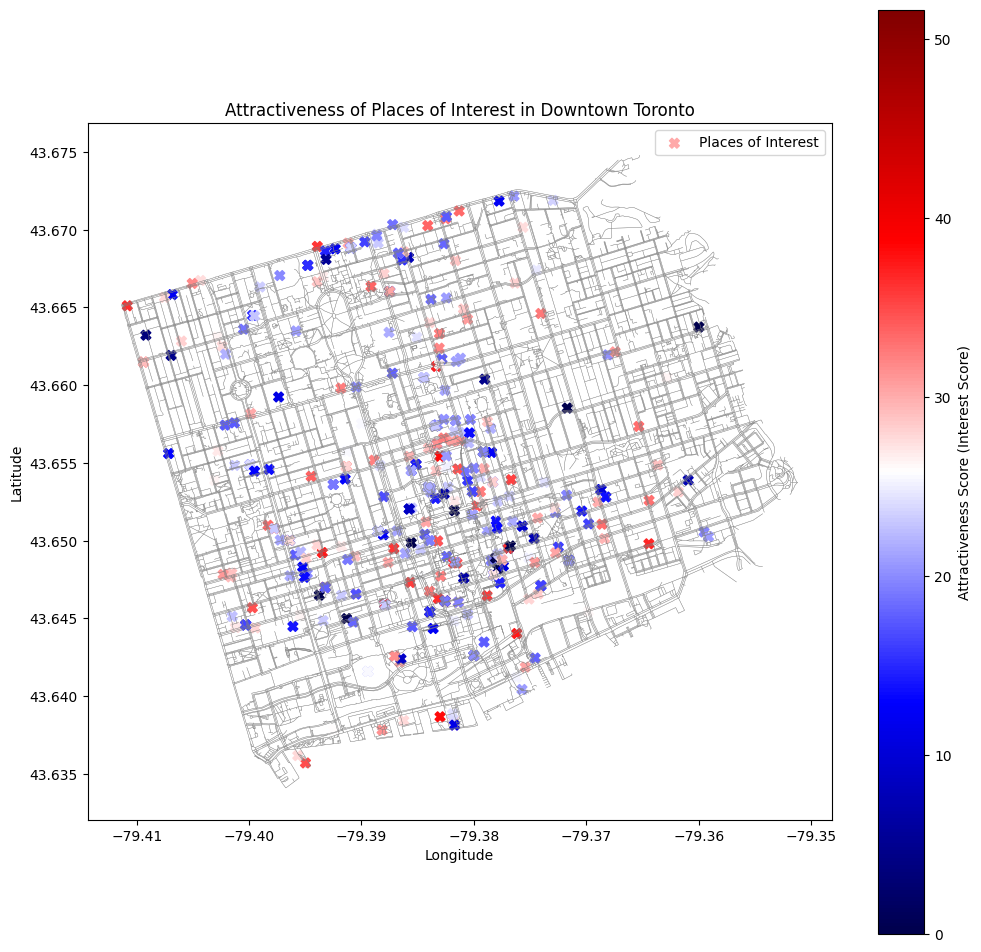

In [44]:
# Graph 6

# Normalize interest scores to map them to a custom color scale from black to yellow
norm = plt.Normalize(places_df["Interest Score"].min(), places_df["Interest Score"].max())
cmap = plt.cm.seismic  # Closely matches the black-red-orange-yellow scale

# Plot the network with intersections and POIs colored by attractiveness
fig, ax = plt.subplots(figsize=(12, 12))
edges.plot(ax=ax, linewidth=0.3, color="gray", alpha=0.7)
# intersections.plot(ax=ax, color="black", markersize=2, label="Intersections")

# Plot POIs with "X" markers based on attractiveness
poi_within_downtown.plot(
    ax=ax,
    color=[cmap(norm(score)) for score in places_df["Interest Score"]],
    marker="X",  # Change marker style to "X"
    markersize=50,  # Adjust size as desired
    label="Places of Interest"
)

# Add colorbar to interpret scores with the custom color scale
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Attractiveness Score (Interest Score)")

plt.title("Attractiveness of Places of Interest in Downtown Toronto")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()

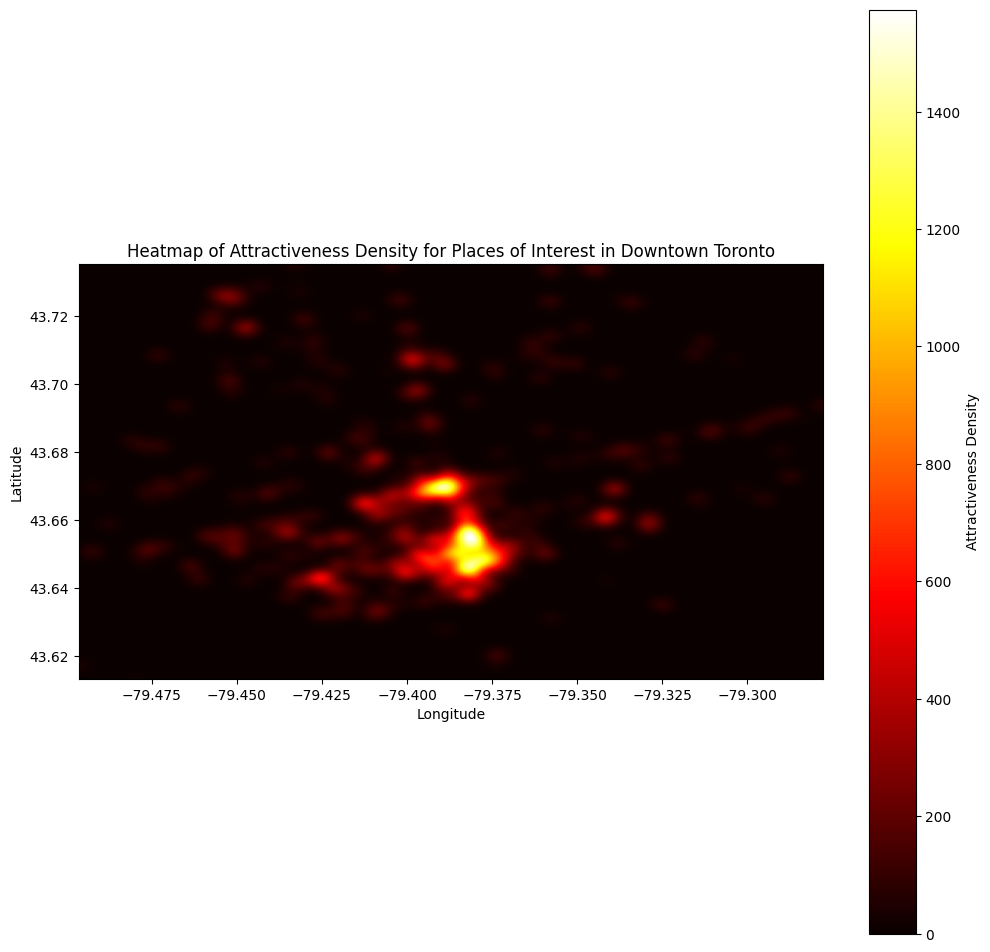

In [45]:
# Graph 7

x = places_df['Longitude']
y = places_df['Latitude']
scores = places_df['Interest Score']

# Create a weighted KDE where high scores have more influence on the density
kde = gaussian_kde([x, y], weights=scores, bw_method=0.08)  # Adjust bw_method for more/less smoothing

# Create a grid over the map area
x_min, x_max = x.min(), x.max()
y_min, y_max = y.min(), y.max()
x_grid, y_grid = np.mgrid[x_min:x_max:500j, y_min:y_max:500j]
positions = np.vstack([x_grid.ravel(), y_grid.ravel()])

# Calculate the density values for each grid position
density = kde(positions).reshape(x_grid.shape)

# Plot the heatmap
fig, ax = plt.subplots(figsize=(12, 12))
plt.imshow(np.rot90(density), cmap='hot', extent=[x_min, x_max, y_min, y_max])
plt.colorbar(label="Attractiveness Density")
# plt.scatter(x, y, c='black', s=1, alpha=0.4, marker='x')  # Add POI locations for reference
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Heatmap of Attractiveness Density for Places of Interest in Downtown Toronto")
plt.show()

In [46]:
# Convert to GeoDataFrame with geometry column
geometry = [Point(xy) for xy in zip(places_df["Longitude"], places_df["Latitude"])]
poi_gdf = gpd.GeoDataFrame(places_df, geometry=geometry, crs="EPSG:4326")

# Define the Interest Score formula if not already in place
def calculate_interest_score(row):
    review_score = row.get("Rating", 0)  # Default to 0 if NaN or missing
    num_reviews = row.get("Total User Ratings", 0)  # Default to 0 if NaN or missing
    return review_score * np.log1p(num_reviews)

# Ensure POIs have an 'Interest Score' calculated
if 'Interest Score' not in places_df.columns:
    places_df["Interest Score"] = places_df.apply(calculate_interest_score, axis=1)

# Re-project POI and road network to EPSG:3857 for consistent distance calculations
poi_gdf = poi_gdf.to_crs(epsg=3857)
G = ox.project_graph(G, to_crs="EPSG:3857")

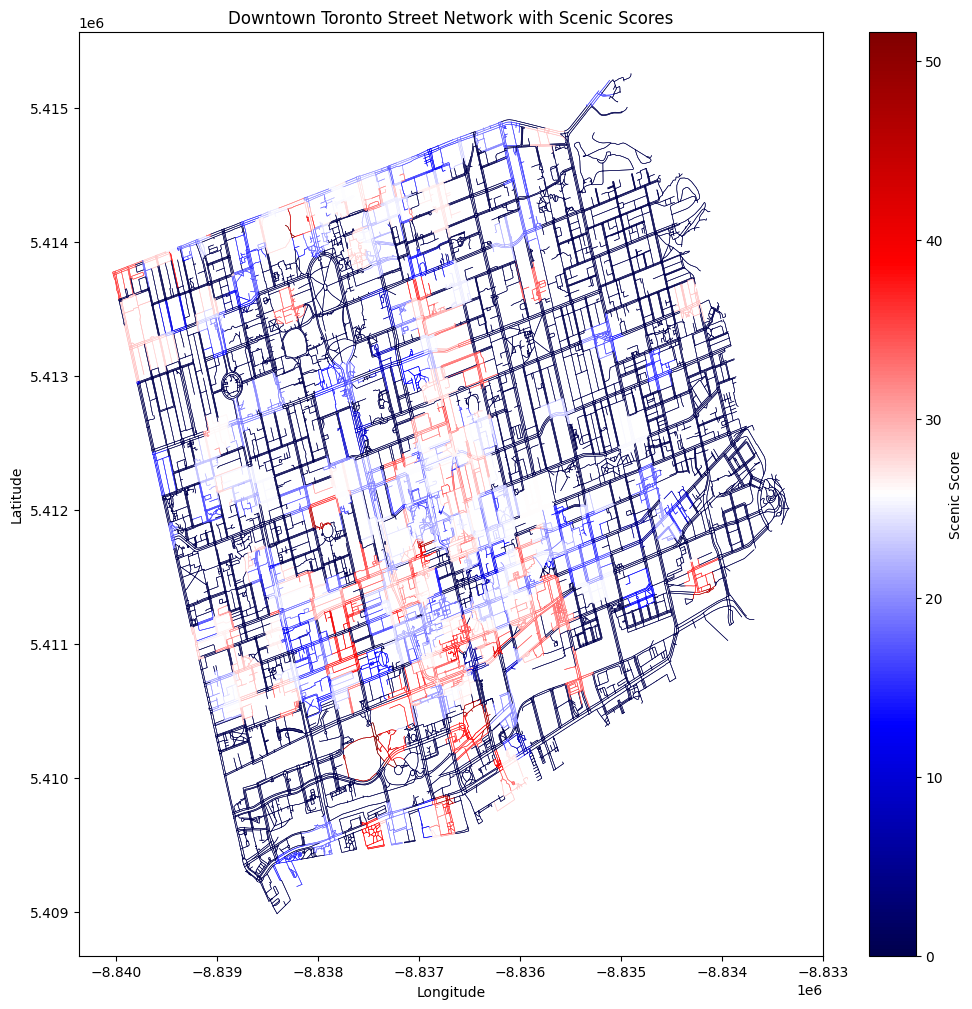

In [47]:
# Assign scenic scores based on nearby POI interest scores
def assign_scenic_scores(G, poi_gdf, radius=150):  # Radius in meters
    for u, v, data in G.edges(data=True):
        # Get start and end points in projected CRS
        u_point = Point((G.nodes[u]['x'], G.nodes[u]['y']))
        v_point = Point((G.nodes[v]['x'], G.nodes[v]['y']))
        line = LineString([u_point, v_point])

        # Calculate the midpoint of the line
        midpoint = line.interpolate(0.5, normalized=True)

        # Find POIs within a radius of the midpoint
        nearby_pois = poi_gdf[poi_gdf.geometry.distance(midpoint) < radius]

        # Calculate the scenic score based on nearby POIs
        scenic_score = nearby_pois["Interest Score"].mean() if not nearby_pois.empty else 0
        data['scenic_score'] = scenic_score  # Attach to the edge

# Apply the function to ensure scores are added
assign_scenic_scores(G, poi_gdf)

# Plot the graph with color-coded scenic scores
fig, ax = plt.subplots(figsize=(12, 12))
scenic_scores = [data['scenic_score'] for _, _, data in G.edges(data=True)]
norm = plt.Normalize(vmin=min(scenic_scores), vmax=max(scenic_scores))
cmap = plt.cm.seismic

for u, v, data in G.edges(data=True):
    # Get the geometry for each road segment
    line = data.get('geometry', LineString([(G.nodes[u]['x'], G.nodes[u]['y']), (G.nodes[v]['x'], G.nodes[v]['y'])]))

    # Color based on scenic score
    color = cmap(norm(data['scenic_score']))
    x, y = line.xy
    ax.plot(x, y, color=color, linewidth=0.4)

# Add colorbar for scenic scores
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Scenic Score")

plt.title("Downtown Toronto Street Network with Scenic Scores")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [48]:
''' # Convert the NetworkX graph back into GeoDataFrames
nodes_gdf, edges_gdf = ox.graph_to_gdfs(G)

# Ensure 'scenic_score' is included in the edges GeoDataFrame
scenic_scores = []
for u, v, key, data in G.edges(keys=True, data=True):
    scenic_scores.append({
        "u": u,
        "v": v,
        "key": key,
        "scenic_score": data.get("scenic_score", 0)  # Default to 0 if missing
    })

# Create a DataFrame for the scenic scores
scenic_scores_df = pd.DataFrame(scenic_scores)

# Merge scenic scores back into the edges GeoDataFrame
edges_gdf = edges_gdf.reset_index()  # Reset index to prepare for merging
merged_edges = edges_gdf.merge(
    scenic_scores_df,
    on=["u", "v", "key"],
    how="left"  # Keep all original data, even if scenic_score is missing
)


merged_edges["scenic_score"] = merged_edges["scenic_score_y"]
merged_edges = merged_edges.drop(columns=["scenic_score_x", "scenic_score_y"]) '''

' # Convert the NetworkX graph back into GeoDataFrames\nnodes_gdf, edges_gdf = ox.graph_to_gdfs(G)\n\n# Ensure \'scenic_score\' is included in the edges GeoDataFrame\nscenic_scores = []\nfor u, v, key, data in G.edges(keys=True, data=True):\n    scenic_scores.append({\n        "u": u,\n        "v": v,\n        "key": key,\n        "scenic_score": data.get("scenic_score", 0)  # Default to 0 if missing\n    })\n\n# Create a DataFrame for the scenic scores\nscenic_scores_df = pd.DataFrame(scenic_scores)\n\n# Merge scenic scores back into the edges GeoDataFrame\nedges_gdf = edges_gdf.reset_index()  # Reset index to prepare for merging\nmerged_edges = edges_gdf.merge(\n    scenic_scores_df,\n    on=["u", "v", "key"],\n    how="left"  # Keep all original data, even if scenic_score is missing\n)\n\n\nmerged_edges["scenic_score"] = merged_edges["scenic_score_y"]\nmerged_edges = merged_edges.drop(columns=["scenic_score_x", "scenic_score_y"]) '

In [49]:
''' for data in G.edges(data=True):
  print(data) '''

' for data in G.edges(data=True):\n  print(data) '

In [50]:
# Initialize counters
total_data_count = 0
edges_without_geometry = 0
edges_without_scenic_score = 0
length = 0

# Iterate through all edges with their attributes
for _, _, data in G.edges(data=True):
    total_data_count += len(data)  # Add the number of attributes in the current edge
    if 'geometry' not in data:    # Check if 'geometry' is missing
        edges_without_geometry += 1
    if 'scenic_score' not in data:
        edges_without_scenic_score += 1
    if 'length' not in data:
        length += 1

# Print the results

print("Total number of attributes across all edges:", total_data_count)
print("Number of edges without 'geometry':", edges_without_geometry)
print("Number of edges without 'scenic_score':", edges_without_scenic_score)
print("Number of edges without 'length':", length)


Total number of attributes across all edges: 336804
Number of edges without 'geometry': 26620
Number of edges without 'scenic_score': 0
Number of edges without 'length': 0


Selected Node Information:
y                                   43.655156
x                                  -79.383641
highway                                   NaN
street_count                                4
railway                                   NaN
ref                                       NaN
geometry        POINT (-79.383641 43.6551563)
Name: 2469059471, dtype: object

In [51]:
''' from shapely.geometry import LineString

# Function to add missing geometry values
def add_missing_geometry(graph):
    for u, v, data in graph.edges(data=True):
        if 'geometry' not in data:
            # Get coordinates of the nodes
            node_u = graph.nodes[u]
            node_v = graph.nodes[v]

            # Ensure the nodes have valid coordinates
            if 'x' in node_u and 'y' in node_u and 'x' in node_v and 'y' in node_v:
                coord_u = (node_u['x'], node_u['y'])  # (longitude, latitude)
                coord_v = (node_v['x'], node_v['y'])  # (longitude, latitude)

                # Create a straight-line geometry
                data['geometry'] = LineString([coord_u, coord_v])
            else:
                raise ValueError(f"Missing coordinates for nodes {u} or {v}.")
    return graph

# Add missing geometries to the graph
G = add_missing_geometry(G) '''

' from shapely.geometry import LineString\n\n# Function to add missing geometry values\ndef add_missing_geometry(graph):\n    for u, v, data in graph.edges(data=True):\n        if \'geometry\' not in data:\n            # Get coordinates of the nodes\n            node_u = graph.nodes[u]\n            node_v = graph.nodes[v]\n\n            # Ensure the nodes have valid coordinates\n            if \'x\' in node_u and \'y\' in node_u and \'x\' in node_v and \'y\' in node_v:\n                coord_u = (node_u[\'x\'], node_u[\'y\'])  # (longitude, latitude)\n                coord_v = (node_v[\'x\'], node_v[\'y\'])  # (longitude, latitude)\n\n                # Create a straight-line geometry\n                data[\'geometry\'] = LineString([coord_u, coord_v])\n            else:\n                raise ValueError(f"Missing coordinates for nodes {u} or {v}.")\n    return graph\n\n# Add missing geometries to the graph\nG = add_missing_geometry(G) '

In [52]:
from shapely.geometry import Point, LineString
import numpy as np

# Adjust scenic scores dynamically based on proximity and visits
def adjust_scenic_scores(G, visited_edges, poi_gdf, radius=100, decay_factor=0.5, threshold=3):
    """
    Reduces scenic scores for roads within a given radius of visited roads.
    - Halves scores on each visit.
    - Sets score to 0 after a threshold number of visits.
    """
    for u, v, data in G.edges(data=True):
        edge_id = (u, v)
        if edge_id in visited_edges:
            continue  # Skip already visited edges

        # Get start and end points
        u_point = Point((G.nodes[u]['x'], G.nodes[u]['y']))
        v_point = Point((G.nodes[v]['x'], G.nodes[v]['y']))
        line = LineString([u_point, v_point])

        # Calculate the midpoint of the line
        midpoint = line.interpolate(0.5, normalized=True)

        # Find POIs within a radius of the midpoint
        nearby_pois = poi_gdf[poi_gdf.geometry.distance(midpoint) < radius]

        # Calculate the scenic score based on nearby POIs
        scenic_score = nearby_pois["Interest Score"].mean() if not nearby_pois.empty else 0

        # Apply decay to the scenic score
        visit_count = visited_edges.get(edge_id, 0)  # Times this edge has been considered
        if visit_count >= threshold:
            scenic_score = 0  # Set to 0 after threshold visits
        else:
            scenic_score *= decay_factor ** visit_count  # Halve score with each visit

        # Update the scenic score for the edge
        data['scenic_score'] = scenic_score
        visited_edges[edge_id] = visit_count + 1  # Increment visit count for this edge



In [53]:
class GeneticSolver:
    def __init__(self, graph, pop_size, route_length, distance_weight=1.0, scenic_weight=1.0, crossover_rate=0.9, mutation_rate=0.1):
        self.graph = graph
        self.pop_size = pop_size
        self.route_length = route_length
        self.distance_weight = distance_weight  # Weight for distance
        self.scenic_weight = scenic_weight  # Weight for scenic score
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.population = self.initialize_population()
        self.best_route = None
        self.best_score = float('inf')
        self.best_fitness_per_generation = []

    def initialize_population(self):
        """Generates the initial population of random routes."""
        population = []
        for _ in range(self.pop_size):
            route = self.generate_random_route()
            population.append(route)
        return population

    def generate_random_route(self):
        """Generates a random connected route starting and ending at the same node."""
        # Filter nodes with a scenic_score > 0
        valid_start_nodes = [
            node for node in self.graph.nodes
            if any(
                edge_data.get('scenic_score', 0) > 0
                for _, _, edge_data in self.graph.edges(node, data=True)
            )
        ]

        if not valid_start_nodes:
            raise ValueError("No valid starting nodes with scenic_score > 0 found in the graph.")

        # Randomly select a start node
        start_node = 3559450462
        route = [start_node]

        visited_nodes = set(route)
        current_node = start_node
        for _ in range(self.route_length // 3 - 2):
            neighbors = [
                neighbor for neighbor in self.graph.neighbors(current_node)
                if neighbor not in visited_nodes and self.have_edge_data(self.graph, current_node, neighbor)
            ]
            if not neighbors:
                break  # No more connected neighbors
            next_node = random.choice(neighbors)
            route.append(next_node)
            visited_nodes.add(next_node)
            current_node = next_node

        # Add the start node as the end node
        route.append(start_node)
        self.repair_route(route)
        return route


    def crossover(self):
        """Performs crossover ensuring connected routes."""
        num_children = self.pop_size // 2
        new_population = []

        for _ in range(num_children):
            if random.random() < self.crossover_rate:
                parent1, parent2 = random.sample(self.population, 2)
                while parent1 == parent2:
                    parent2 = random.choice(self.population)
                start, end = sorted(random.sample(range(1, len(parent1)-1), 2))
                child1 = parent1[:start] + [node for node in parent2 if node not in parent1[start:end]] + parent1[end:]
                child2 = parent2[:start] + [node for node in parent1 if node not in parent2[start:end]] + parent2[end:]

                # Repair and validate connectivity
                child1 = self.repair_route(child1)
                child2 = self.repair_route(child2)

                if child1 and self.is_route_connected(child1) and len(child1) > 5:
                    new_population.append(child1)
                if child2 and self.is_route_connected(child2) and len(child2) > 5:
                    new_population.append(child2)

        self.population.extend(new_population)

    def mutate(self):
        """Performs mutation on the population, ensuring connectivity."""
        for i in range(len(self.population)):
            if random.random() < self.mutation_rate:
                route = self.population[i]

                # Swap two random nodes
                idx1, idx2 = random.sample(range(1, len(route)-1), 2)
                route[idx1], route[idx2] = route[idx2], route[idx1]

                # Repair and validate connectivity
                repaired_route = self.repair_route(route)
                if repaired_route and self.is_route_connected(repaired_route):
                    self.population[i] = repaired_route

    def fitness_func(self):
        """Evaluates the fitness of each route."""
        fitness_scores = []
        # self.population = random.sample(self.population, k=min(self.pop_size, len(self.population)))

        for route in self.population:
            if len(route) < 6:
                self.population.remove(route)
            elif len(route) > self.route_length:
                self.population.remove(route)
            else:
                total_distance = 0
                total_scenic_score = 0
                penalty = 0
                for i in range(len(route) - 1):
                    u, v = route[i], route[i + 1]
                    edge_data = self.graph.get_edge_data(u, v, default={})
                    # Check reverse edge if necessary
                    if not edge_data:
                        edge_data = self.graph.get_edge_data(v, u, default={})

                    # Penalize if edge_data is missing
                    if not edge_data:
                        continue

                    # Accumulate distance and scenic score
                    total_distance += edge_data[0].get('length', 0)
                    total_scenic_score += edge_data[0].get('scenic_score', 0)
                # Combine objectives into a fitness value

                fitness = (self.distance_weight * total_distance) - (self.scenic_weight * total_scenic_score)
                if(fitness == 0): continue
                fitness_scores.append(fitness)
                # Track the best route
                if fitness < self.best_score:
                    self.best_score = fitness
                    self.best_route = route
        print(f"Fitness scores for current generation: {fitness_scores}")
        self.best_fitness_per_generation.append(self.best_score)
        # Sort population by fitness
        self.population = [route for _, route in sorted(zip(fitness_scores, self.population))]

    def select_parents(self):
        """Selects the top half of the population as parents."""
        self.population = random.sample(self.population, k=min(self.pop_size, len(self.population)))

    def solve(self, generations=100):
        """Runs the genetic algorithm for a specified number of generations."""
        for generation in range(generations):
            self.crossover()
            self.mutate()
            self.fitness_func()
            self.select_parents()
            print(f"Generation {generation + 1}: Best Fitness = {self.best_score}")

        self.best_fitness_per_generation = [cost - min(self.best_fitness_per_generation) for cost in self.best_fitness_per_generation]
        print(f"Costs for all generation: {self.best_fitness_per_generation}")

        return self.best_route, self.best_score, self.best_fitness_per_generation

    def is_route_connected(self, route):
        """Checks if the given route is fully connected in the graph."""
        for i in range(len(route) - 1):
            if not self.graph.has_edge(route[i], route[i + 1]) and self.have_edge_data(self.graph,route[i], route[i + 1]):
                return False  # Disconnected
        return True

    def have_edge_data(self, G, current_node, next_node):
        edge_data = G.get_edge_data(current_node, next_node, default=None)
        if edge_data or G.get_edge_data(next_node,current_node , default=None):
            return True
        return False

    def repair_route(self, route):
        """Repair a route by replacing invalid edges."""
        repaired_route = [route[0]]  # Start with the first node
        for i in range(1, len(route)):
            current_node = repaired_route[-1]
            next_node = route[i]
            if next_node != route[-1]:
              if self.graph.has_edge(current_node, next_node) and self.have_edge_data(self.graph, current_node, next_node):
                  repaired_route.append(next_node)
              else:
                  # Find a valid replacement node
                  neighbors = [
                      neighbor for neighbor in self.graph.neighbors(current_node)
                      if neighbor not in repaired_route and self.have_edge_data(self.graph, current_node, neighbor)
                  ]
                  if neighbors:
                      repaired_route.append(random.choice(neighbors))
                  else:
                      return None  # Unable to repair the route
            else:
              if self.graph.has_edge(current_node, next_node) and self.have_edge_data(self.graph, current_node, next_node):
                  repaired_route.append(next_node)
                  break
              else:
                  additional_route = self.find_route(current_node, next_node, [repaired_route[4:-1]])
                  repaired_route.extend(additional_route)
                  break
        return repaired_route

    def find_route(self, start_node, end_node, unavailables = [], retries = 300):
        if retries <= 0:
          raise Exception("No route found")
        route = [start_node]
        current_node = start_node
        while current_node != end_node:
            neighbors = [
                neighbor for neighbor in self.graph.neighbors(current_node)
                if neighbor not in route and neighbor not in unavailables and self.have_edge_data(self.graph, current_node, neighbor)
            ]
            if not neighbors:
                unavailables.append(current_node)
                route.pop()
                current_node = route[-1]
            else:
                next_node = random.choice(neighbors)
                route.append(next_node)
                current_node = next_node
        return route




In [56]:
# Parameters
pop_size = 100
route_length = 150
generations = 30
distance_weight = 0.5  # Adjust to prioritize distance
scenic_weight = 2    # Adjust to prioritize scenic score
crossover_rate = 0.9
mutation_rate = 0.1

# Create the solver
solver = GeneticSolver(
    graph=G,
    pop_size=pop_size,
    route_length=route_length,
    distance_weight=distance_weight,
    scenic_weight=scenic_weight,
    crossover_rate=crossover_rate,
    mutation_rate=mutation_rate
)

# Solve
best_route, best_fitness, costs = solver.solve(generations=generations)
print("Best Route:", best_route)
print("Best Fitness:", best_fitness)

Fitness scores for current generation: [-693.4998313777038, -408.0683719157324, -183.45635374823866, -209.88619673967372, -652.4109882863576, -297.6871685430591, -1270.1732356695402, -302.23658132282594, -183.45635374823866, -1177.5383074416673, -1246.6315564021625, -362.2896373632895, -441.34527515182265, -217.1735107320029, -664.6814524108902, -373.1517004619631, -1705.8724597388818, -701.4323371150563, -379.9039570192438, -382.7317969494295, -304.60221988250544, -1176.9773973447523, -1686.3646019249077, -601.999521429402, -260.46450753128727, -744.9356070475717, -474.89309668350853, -373.1517004619631, -498.49150953180833, -373.1517004619631, -691.01446050806, -373.1517004619631, -247.02435227680348, -275.01710239763634, -362.2896373632895, -629.3406832222997, -1780.1605891899767, -446.00255745120074, -384.89526521079125, -382.7317969494295, -408.68821400297134, -1365.0388857115684, -297.6871685430591, -297.6871685430591, -298.73592004150646, -671.550963953659, -959.1693729333983, -

Total number of edges(roads): 147


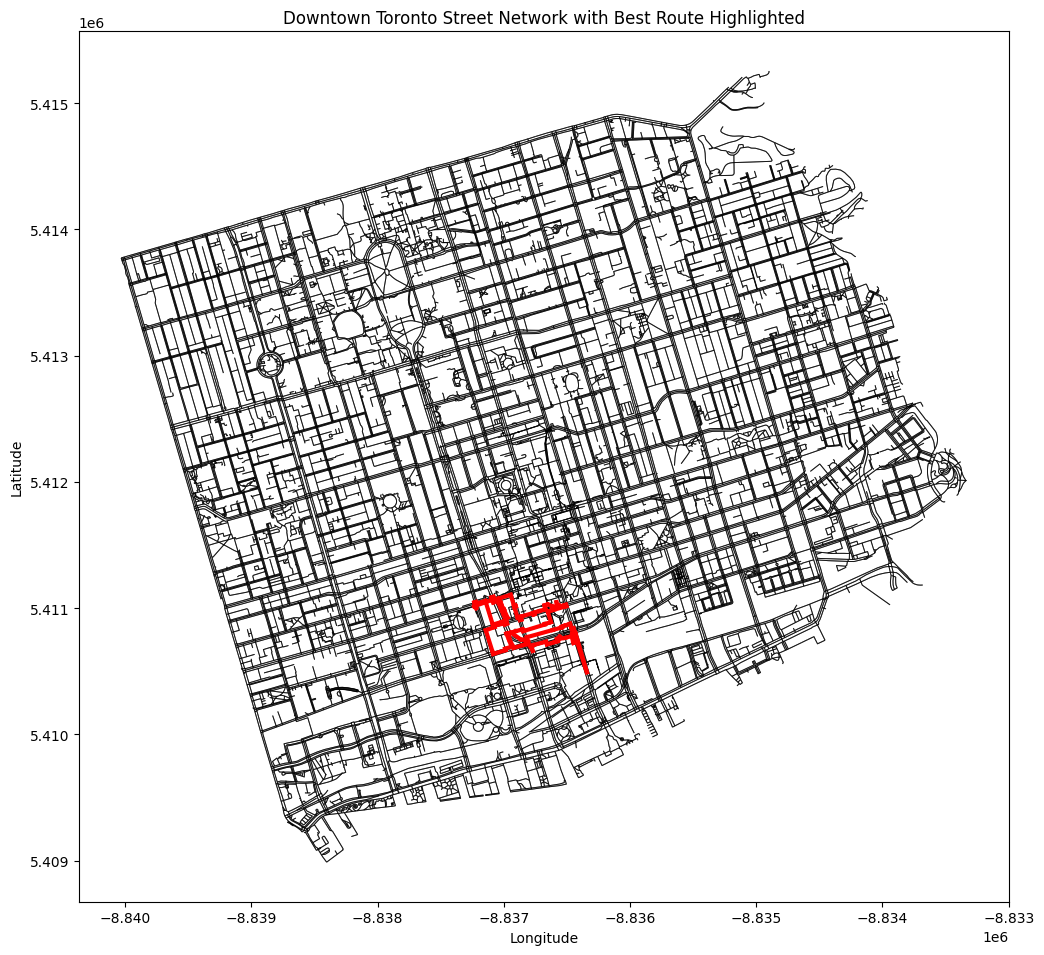

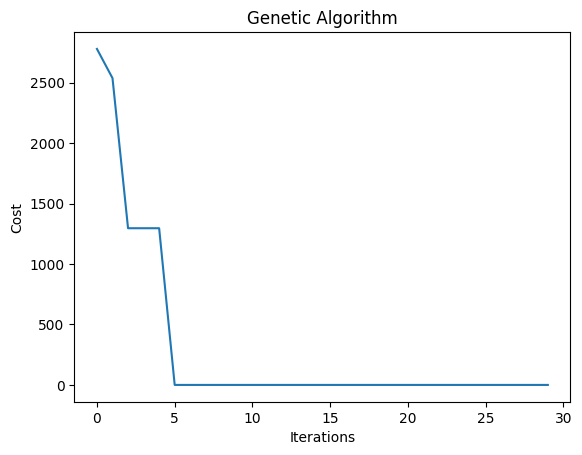

In [57]:
nodes, edges = ox.graph_to_gdfs(G)
intersections = nodes[nodes['street_count'] > 1]  # Filter to only intersection nodes

# Plot the network
fig, ax = plt.subplots(figsize=(12, 12))
edges.plot(ax=ax, linewidth=0.7, color="black", alpha=0.7)

# Highlight the route if found
#if len(route) == 10:
for i in range(len(best_route) - 1):
    u, v = best_route[i], best_route[i + 1]

    edge_data = G.get_edge_data(u, v, default=None)

    if not edge_data:
        edge_data = G.get_edge_data(v, u, default=None)
    if edge_data:
        # Check if 'geometry' exists; if not, create a simple line between nodes
        if 'geometry' in edge_data:
            edge_geom = edge_data['geometry']
        else:
            # Get coordinates of the nodes to create a straight line
            x_start, y_start = G.nodes[u]['x'], G.nodes[u]['y']
            x_end, y_end = G.nodes[v]['x'], G.nodes[v]['y']
            edge_geom = [(x_start, y_start), (x_end, y_end)]

            # Plot the edge in red
        if isinstance(edge_geom, list):  # Case where geometry is manually created
            x_coords, y_coords = zip(*edge_geom)
            ax.plot(x_coords, y_coords, color='red', linewidth=3)
        else:  # Case where geometry exists as a LineString
            ax.plot(*edge_geom.xy, color='red', linewidth=3)
    '''
    else:
        x_start, y_start = G.nodes[u]['x'], G.nodes[u]['y']
        x_end, y_end = G.nodes[v]['x'], G.nodes[v]['y']
        edge_geom = [(x_start, y_start), (x_end, y_end)]

            # Plot the edge in red
        if isinstance(edge_geom, list):  # Case where geometry is manually created
            x_coords, y_coords = zip(*edge_geom)
            ax.plot(x_coords, y_coords, color='red', linewidth=3)
        else:  # Case where geometry exists as a LineString
            ax.plot(*edge_geom.xy, color='red', linewidth=3)
        print(f"Edge data missing for {u} -> {v}, skipping.")

    '''

print(f'Total number of edges(roads): {len(best_route)}')
plt.title("Downtown Toronto Street Network with Best Route Highlighted")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


# Plot Iterations vs Cost
plt.plot(costs)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("Genetic Algorithm")
plt.show()

In [ ]:
# Old Algorithm

''' class GeneticSolver:
    def __init__(self, graph, pop_size, route_length, distance_weight=1.0, scenic_weight=1.0, crossover_rate=0.9, mutation_rate=0.1):
        self.graph = graph
        self.pop_size = pop_size
        self.route_length = route_length
        self.distance_weight = distance_weight  # Weight for distance
        self.scenic_weight = scenic_weight  # Weight for scenic score
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.population = self.initialize_population()
        self.best_route = None
        self.best_score = float('inf')
        self.best_fitness_per_generation = []

    def initialize_population(self):
        """Generates the initial population of random routes."""
        population = []
        for _ in range(self.pop_size):
            route = self.generate_random_route()
            population.append(route)
        return population

    def generate_random_route(self):
        """Generates a random connected route starting from a node with a scenic_score > 0."""
        # Filter nodes with a scenic_score > 0
        valid_start_nodes = [
            node for node in self.graph.nodes
            if any(
                edge_data.get('scenic_score', 0) > 0
                for _, _, edge_data in self.graph.edges(node, data=True)
            )
        ]

        if not valid_start_nodes:
            raise ValueError("No valid starting nodes with scenic_score > 0 found in the graph.")

        # Randomly select a start node
        start_node = random.choice(valid_start_nodes)
        route = [start_node]

        visited_nodes = set(route)
        # Generate the rest of the route
        current_node = start_node
        for _ in range(self.route_length - 1):
            neighbors = [
                neighbor for neighbor in self.graph.neighbors(current_node)
                if neighbor not in visited_nodes and self.have_edge_data(self.graph,current_node,neighbor)
            ]
            if not neighbors:
                break  # No more connected neighbors
            next_node = random.choice(neighbors)
            route.append(next_node)
            current_node = next_node

        return route

    def crossover(self):
        """Performs crossover ensuring connected routes."""
        num_children = self.pop_size // 2
        new_population = []

        for _ in range(num_children):
            if random.random() < self.crossover_rate:
                parent1, parent2 = random.sample(self.population, 2)
                start, end = sorted(random.sample(range(len(parent1)), 2))
                child1 = parent1[:start] + [node for node in parent2 if node not in parent1[:start]]
                child2 = parent2[:start] + [node for node in parent1 if node not in parent2[:start]]

                # Repair and validate connectivity
                child1 = self.repair_route(child1)
                child2 = self.repair_route(child2)

                if child1 and self.is_route_connected(child1):
                    new_population.append(child1)
                if child2 and self.is_route_connected(child2):
                    new_population.append(child2)

        self.population.extend(new_population)

    def mutate(self):
        """Performs mutation on the population, ensuring connectivity."""
        for i in range(len(self.population)):
            if random.random() < self.mutation_rate:
                route = self.population[i]

                # Swap two random nodes
                idx1, idx2 = random.sample(range(len(route)), 2)
                route[idx1], route[idx2] = route[idx2], route[idx1]

                # Repair and validate connectivity
                repaired_route = self.repair_route(route)
                if repaired_route and self.is_route_connected(repaired_route):
                    self.population[i] = repaired_route

    def fitness_func(self):
        """Evaluates the fitness of each route."""
        fitness_scores = []
        for route in self.population:
            total_distance = 0
            total_scenic_score = 0
            penalty = 0
            for i in range(len(route) - 1):
                u, v = route[i], route[i + 1]
                edge_data = self.graph.get_edge_data(u, v, default={})
                # Check reverse edge if necessary
                if not edge_data:
                    edge_data = self.graph.get_edge_data(v, u, default={})

                # Penalize if edge_data is missing
                if not edge_data:
                    continue

                # Accumulate distance and scenic score
                total_distance += edge_data[0].get('length', 0)
                total_scenic_score += edge_data[0].get('scenic_score', 0)
            # Combine objectives into a fitness value

            fitness = (self.distance_weight * total_distance) - (self.scenic_weight * total_scenic_score)
            if(fitness == 0): continue
            fitness_scores.append(fitness)
            # Track the best route
            if fitness < self.best_score:
                self.best_score = fitness
                self.best_route = route
        print(f"Fitness scores for current generation: {fitness_scores}")
        self.best_fitness_per_generation.append(self.best_score)
        # Sort population by fitness
        self.population = [route for _, route in sorted(zip(fitness_scores, self.population))]

    def select_parents(self):
        """Selects the top half of the population as parents."""
        self.population = self.population[:self.pop_size // 2]

    def solve(self, generations=100):
        """Runs the genetic algorithm for a specified number of generations."""
        for generation in range(generations):
            self.crossover()
            self.mutate()
            self.fitness_func()
            self.select_parents()
            print(f"Generation {generation + 1}: Best Fitness = {self.best_score}")

        self.best_fitness_per_generation = [cost - min(self.best_fitness_per_generation) for cost in self.best_fitness_per_generation]
        print(f"Costs for all generation: {self.best_fitness_per_generation}")

        return self.best_route, self.best_score, self.best_fitness_per_generation

    def is_route_connected(self, route):
        """Checks if the given route is fully connected in the graph."""
        for i in range(len(route) - 1):
            if not self.graph.has_edge(route[i], route[i + 1]) and self.have_edge_data(self.graph,route[i], route[i + 1]):
                return False  # Disconnected
        return True

    def have_edge_data(self, G, current_node, next_node):
        edge_data = G.get_edge_data(current_node, next_node, default=None)
        if edge_data or G.get_edge_data(next_node,current_node , default=None):
            return True
        return False

    def repair_route(self, route):
        """Repair a route by replacing invalid edges."""
        repaired_route = [route[0]]  # Start with the first node
        for i in range(1, len(route)):
            current_node = repaired_route[-1]
            next_node = route[i]
            if self.graph.has_edge(current_node, next_node) and self.have_edge_data(self.graph, current_node, next_node):
                repaired_route.append(next_node)
            else:
                # Find a valid replacement node
                neighbors = [
                    neighbor for neighbor in self.graph.neighbors(current_node)
                    if neighbor not in repaired_route and self.have_edge_data(self.graph, current_node, neighbor)
                ]
                if neighbors:
                    repaired_route.append(random.choice(neighbors))
                else:
                    return None  # Unable to repair the route
        return repaired_route
 '''